In [2]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import xarray as xr


In [18]:

import utils
data=utils.load_data_set()

In [4]:
#data.to_csv("plp2019.csv")#save dataset

In [19]:
def save_bands(data_frame,arguments=["B02","B03","B04","B08"]):
    for i in data.index.unique(level=0):
        shape=(len(data_frame.x.unique()),len(data_frame.y.unique()),len(arguments))
        to_save=np.array(data_frame.loc[i][arguments]).reshape(shape)
        np.save(i+str(arguments),to_save)
#save_bands(data)#to save the numpy array repressenting each band for each image


In [21]:
def get_image(data,argument):
    if len(argument)==1:


        shape=(len(data.y.unique()),len(data.x.unique()))
        return np.array(data[argument]).reshape(shape)
    elif len(argument)==3:#image couleur
        shape=(len(data.y.unique()),len(data.x.unique()),3)
        return np.array(data[argument]).reshape(shape)

    

In [6]:
from matplotlib.colors import ListedColormap
cmap_2=ListedColormap(["white","green","yellow","red", "blue"])


def plot_label(data_frame,arguments,normalize=-1,alpha=-1,cmap=cmap_2):#normalize donne la valeur pour normaliser. si non donnée ou inf à 0, on prend le max de l'image
#cmap="gist_rainbow"
    """
    alpha pour afficher uniquement les labels (les 0 ne sont pas pris en compte)
    cmap marche uniquement pour les data à une dimension
    """
    shape=(len(data_frame.y.unique()),len(data_frame.x.unique()))
    to_plot=np.array(data_frame[arguments]).reshape(shape)


    if alpha>=0:#si on utilise le parametre alpha -> on est sur l'image avec le label=1
        alphas=alpha*to_plot[:,:]
        print(alphas.shape)
       
    else:
        alphas=1.
   
    
    plt.imshow(to_plot,cmap=cmap,vmin=0,vmax=4)#,alpha=alphas
    

In [7]:
def prediction_fdi_decrite(data,distance_min=4):#test avec la valeur décrite de l'
    data["fdi"]=data["B08"]-(data["B06"]+(data["B11"]-data["B06"])*0.1926)
    data["prediction"]=1*(data["fdi"]>0.005)*1*(data["distance"]>=distance_min)

    return data

In [8]:
def prediction_fdi(data,distance_min=4,seuil=0.013):#valeur réél de l'indice fdi décrit par Lauren Biermann and all 2020)

    parametre=10*(832.5-664.6)/(1613.7-664.6)
    
    data["fdi"]=data["B08"]-(data["B06"]+(data["B11"]-data["B06"])*parametre)
    data["prediction"]=1*(data["fdi"]>seuil)*1*(data["distance"]>=distance_min)

    return data

In [9]:
from pysptools.abundance_maps.amaps import FCLS
#unmixing (endmenber de l'article fdi, Lauren Biermann and all 2020) + moyenne image
def prediction_unmixing(data,distance_min=4,seuil=0.3):
    
    for i in data.index.unique(level=0):
        
    
        image=data.loc[i]

        target=image[["B04","B06","B08","B11"]][image["distance"]>=distance_min].dropna()
        
        spectral_sign=np.array([np.array(target.mean()),[0.06,0.07,0.06,0.035],[0.03825,0.037625,0.0334,0.055125]])#,])#])[ 0.10384066, 0.13632251, 0.16474463, 0.3045134]
        resultat=FCLS(np.array(target),spectral_sign)
        prediction_image=(resultat[:,1]>seuil)*1

        data.loc[i,"prediction"]=np.array(pd.Series(prediction_image,index=target.index).reindex(image.index))#reindex to correspound to image
        
    return data


In [10]:
#unmixing avec endmenber article chalenge and potential, Chuanmin Hu 2021 + moyenne image
from pysptools.abundance_maps.amaps import FCLS


def prediction_unmixingv2(data_frame,distance_min=4,with_alguae=False,with_calm=False):
    data=data_frame.copy()
    shape=(len(data.y.unique()),len(data.x.unique()))

    for i in data.index.unique(level=0):
        image=data.loc[i]
        target=image[["B02","B03","B04","B08"]][image["distance"]>=distance_min].dropna()
        if with_alguae:
            if with_calm:
                 spectral_sign=np.array([[0.007,0.018,0.011,0.001],[ 0.1, 0.13, 0.19,0.23],[0.025,0.07,0.06,0.021],[0.028,0.006,0.001,0.0001]])
            else:
                spectral_sign=np.array([[0.007,0.018,0.011,0.001],[ 0.1, 0.13, 0.19,0.23],[0.025,0.07,0.06,0.021]])#calm :[0.028,0.006,0.001,0.0001] -> ne semble pas prédire mieux avec les calmes
        else:
            if with_calm:
                spectral_sign=np.array([[0.007,0.018,0.011,0.001],[ 0.1, 0.13, 0.19,0.23],[0.028,0.006,0.001,0.0001]])
            else:
                spectral_sign=np.array([[0.007,0.018,0.011,0.001],[ 0.1, 0.13, 0.19,0.23]])
        
        resultat=FCLS(np.array(target),spectral_sign)
        k=1#channel (1 pour plastique)
        data.loc[i,"prediction"]=np.array(pd.Series(resultat[:,k],index=target.index).reindex(image.index))
        im_pred=np.array(data.loc[i]["prediction"]).reshape(shape).astype(np.float64)
        dst = cv.Laplacian(im_pred, -1)
        variance=np.var(dst[np.logical_not(np.isnan(dst))])
        seuil=np.sqrt(variance)
        data.loc[i,"prediction"]=((dst<-seuil).flatten())*1#abs(dst)>abs(seuil
            #plt.imshow(im_pred)#voir complementarité turbid/ clear
           
    return data


In [11]:
#algorithme naif basée sur bande B08
def prediction_B08(data,distance_min=4):#detecte es anomalie avec pour critere laplacien>variance
    shape=(len(data.x.unique()),len(data.y.unique()))
    
    for i in data.index.unique(level=0):
        image=data.loc[i]
        im_pred=np.array(data.loc[i]["B08"]).reshape(shape).astype(np.float64)
        dst = cv.Laplacian(im_pred, -1)
        variance=np.var(dst[np.logical_not(np.isnan(dst))])
        seuil=np.sqrt(variance)
        data.loc[i,"prediction"]=((dst<-seuil).flatten())*1#abs(dst)>abs(seuil
            #plt.imshow(im_pred)#voir complementarité turbid/ clear
           
    return data


In [12]:
#algorithme naif avec seuil basée sur SNR théorique (pas forcément obtimal)
def prediction_B08_SNR(data_frame,distance_min=4):
    data=data_frame.copy()
    shape=(len(data.y.unique()),len(data.y.unique()))
    resultat=np.zeros(shape)
    for i in data.index.unique(level=0):
        image=data.loc[i]
        im_pred=np.array(data.loc[i]["B08"]).reshape(shape).astype(np.float64)
        
        dif=abs(im_pred[:,:-1]-im_pred[:,1:])
        print(dif.flatten().shape)
        print(data.loc[i,"prediction"])
        resultat[:,:-1]=dif
        data.loc[i,"prediction"]=(resultat.flatten()>0.00104)*1#minimum : 0.00104 (theorical)

        

        plt.figure()
        plt.imshow(dif>0.00104)
        
        plt.colorbar()
        plt.figure()
        plt.hist(dif.flatten())
    return data


In [13]:
from pysptools.detection.detect import MatchedFilter

#detection de plastique avec matched filtering (ici on a les différenente contrainte, contrairement à dans le fichier reprise_implementation

def prediction_MF(data,distance_min=4,seuil=0.3):
    
    for i in data.index.unique(level=0):
        
    
        image=data.loc[i]

        target=image[["B02","B03","B04","B08"]][image["distance"]>=distance_min].dropna()
        
        spectral_sign=np.array([ 0.1, 0.13, 0.19,0.23])#,])#])[ 0.10384066, 0.13632251, 0.16474463, 0.3045134]
        resultat=MatchedFilter(np.array(target),spectral_sign)
        prediction_image=(resultat>seuil)*1

        data.loc[i,"prediction"]=np.array(pd.Series(prediction_image,index=target.index).reindex(image.index))#reindex to correspound to image
        
    return data


In [14]:
from sklearn.ensemble import IsolationForest

def prediction_isolation_forest(data,distance_min=4,seuil=-0.5):

    for i in data.index.unique(level=0):
        image=data.loc[i]
        target=image[["B02","B03","B04","B11"]].dropna()
        clf = IsolationForest(random_state=0).fit(target)
        resultat=clf.score_samples(target)
        prediction_image=(resultat<seuil)*1
    
        data.loc[i,"prediction"]=np.array(pd.Series(prediction_image,index=target.index).reindex(image.index))
    return data



n               
2018-06-07  0       0.0
            1       0.0
            2       0.0
            3       0.0
            4       0.0
                   ... 
2019-06-07  1003    4.0
            1004    4.0
            1005    4.0
            1006    4.0
            1007    4.0
Name: visualisation, Length: 6048, dtype: float64


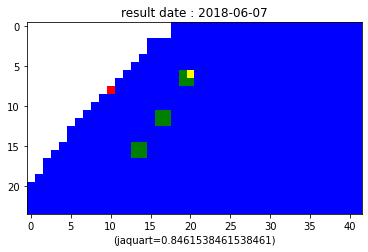

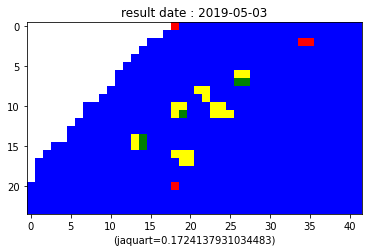

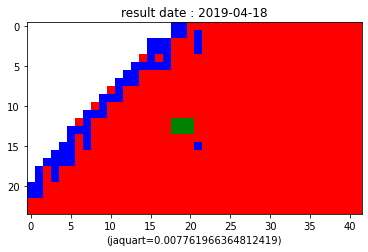

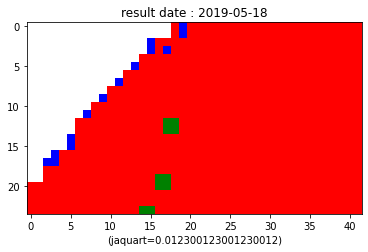

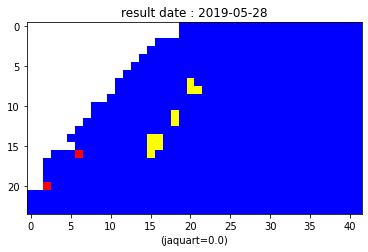

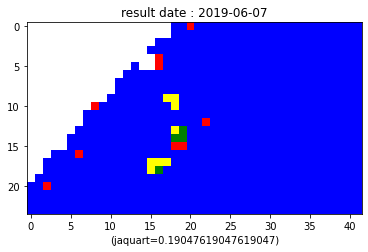

In [25]:
import cv2 as cv
#permet d'avoir les résultats de l'algorithme (et de comparer les différents algorithmes)
def show_result(data):
    """
    data est le dataframe dans lesquel on a mis toute les images
    les résultats de l'algorithme sont dans résultat: resultat = 1 si plastique détecté, 0 sinon
    les labels sont dans label
    
    """
    data_frame=data.copy()
    data_frame["tp"]=1.*(data_frame["prediction"])*1*(data_frame["label"]==1)#true positive
    data_frame["miss"]=2.*(data_frame["prediction"]!=1)*1*(data_frame["label"]==1)#miss positive
    data_frame["fp"]=3.*(data_frame["prediction"])* 1*(data_frame["label"]==0)#false positive
    data_frame["fn"]=4.*(data_frame["prediction"]!=1)*1*(data_frame["label"]==0)*(1-data_frame["B01"].isna())#false negative
    


    data_frame["visualisation"]=(data_frame["tp"]+data_frame["fp"]+data_frame["miss"]+data_frame["fn"]).astype(np.float64)
    
    print(data_frame["visualisation"])
    
    for i in data_frame.index.unique(level=0):
    
        plt.figure()
        
        image=data_frame.loc[i]
        count=image[(image!=0)].count()
        jq=count["tp"]/(count["fp"]+count["tp"]+count["miss"])
        
        plt.title("result"+" date : "+str(i))
        plt.xlabel("(jaquart="+str(jq)+")")
        plot_label(image,arguments=["visualisation"])
        #plt.savefig("unmixing-"+str(i))#pour sauvegarder
    return data_frame
data=prediction_fdi(data,distance_min=0,seuil=0.013)#remplacer cette ligne par n'importe quelle algorithme pour voir les résultats
#plt.colorbar()
to_plot=show_result(data)

0.985988151860075 0.7922583407297632
0.9926058890578806 0.772949730595131
0.9896226866911023 0.7445175482646927
0.9792224524263586 0.8629497668585424
0.9969639878218562 0.932182446081872
0.9885566699255753 0.7247647028563747
n               
2018-06-07  0       0.0
            1       0.0
            2       0.0
            3       0.0
            4       0.0
                   ... 
2019-06-07  1003    4.0
            1004    4.0
            1005    4.0
            1006    4.0
            1007    4.0
Name: visualisation, Length: 6048, dtype: float64


lon   x   y        lat       B01       B02       B03  \
n                                                                             
2018-06-07 0     26.564011   0   0  39.109287       NaN       NaN       NaN   
           1     26.564127   1   0  39.109287       NaN       NaN       NaN   
           2     26.564241   2   0  39.109287       NaN       NaN       NaN   
           3     26.564358   3   0  39.109291       NaN       NaN       NaN   
           4     26.564474   4   0  39.109291       NaN       NaN       NaN   
...                    ...  ..  ..        ...       ...       ...       ...   
2019-06-07 1003  26.568302  37  23  39.107231  0.036926  0.035275  0.030083   
           1004  26.568419  38  23  39.107231  0.037197  0.037299  0.032572   
           1005  26.568535  39  23  39.107231  0.037197  0.037173  0.031452   
           1006  26.568649  40  23  39.107231  0.037197  0.036793  0.030208   
           1007  26.568766  41  23  39.107235  0.037197  0.036667  0.029959   

                      B04       B05       B06  ...       B12  label  \
n                                              ...                    
2018-06-07 0          NaN       NaN       NaN  ...       NaN    0.0   
           1          NaN       NaN       NaN  ...       NaN    0.0   
           2          NaN       NaN       NaN  ...       NaN    0.0   
           3          NaN       NaN       NaN  ...       NaN    0.0   
           4          NaN       NaN       NaN  ...       NaN    0.0   
...                   ...       ...       ...  ...       ...    ...   
2019-06-07 1003  0.022997  0.022115  0.024495  ...  0.017037    0.0   
           1004  0.023799  0.021659  0.024382  ...  0.016931    0.0   
           1005  0.022882  0.021659  0.024382  ...  0.016931    0.0   
           1006  0.022080  0.020402  0.022686  ...  0.016399    0.0   
           1007  0.022080  0.020402  0.022686  ...  0.016399    0.0   

                  distance  prediction       fdi   tp  miss   fp   fn  \
n                                                                       
2018-06-07 0      0.000000           0       NaN  0.0   0.0  0.0  0.0   
           1      0.000000           0       NaN  0.0   0.0  0.0  0.0   
           2      0.000000           0       NaN  0.0   0.0  0.0  0.0   
           3      0.000000           0       NaN  0.0   0.0  0.0  0.0   
           4      0.000000           0       NaN  0.0   0.0  0.0  0.0   
...                    ...         ...       ...  ...   ...  ...  ...   
2019-06-07 1003  28.425341           0  0.005424  0.0   0.0  0.0  4.0   
           1004  29.206164           0  0.008767  0.0   0.0  0.0  4.0   
           1005  30.000000           0  0.007753  0.0   0.0  0.0  4.0   
           1006  30.805844           0  0.005435  0.0   0.0  0.0  4.0   
           1007  31.622777           0  0.005435  0.0   0.0  0.0  4.0   

                 visualisation  
n                               
2018-06-07 0               0.0  
           1               0.0  
           2               0.0  
           3               0.0  
           4               0.0  
...                        ...  
2019-06-07 1003            4.0  
           1004            4.0  
           1005            4.0  
           1006            4.0  
           1007            4.0  

[6048 rows x 24 columns]

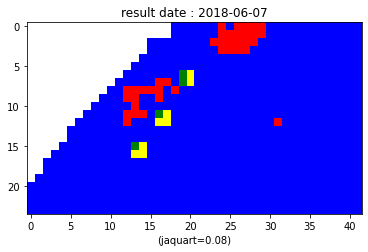

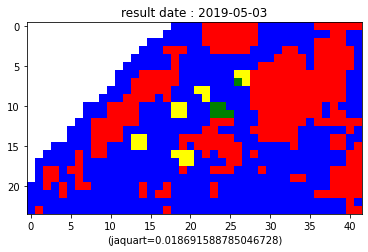

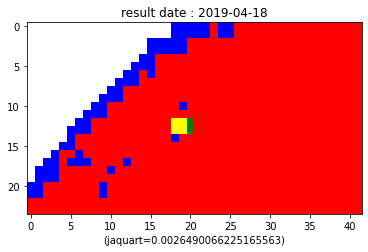

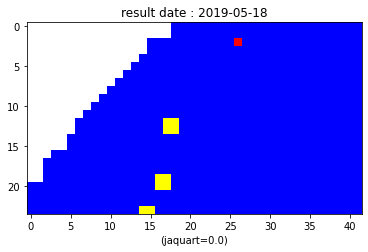

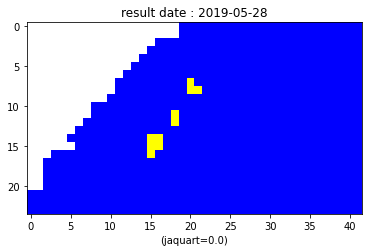

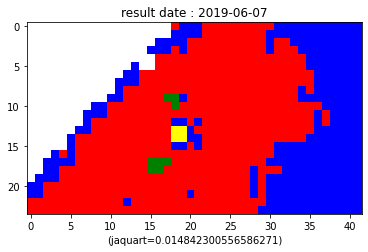

In [26]:
import math

#implementation SAM: ne fonctionne pas trés bien dans notre cas
def calc_SAM(input,signature):
    """
    input : data_frame/numpy array de forme (N_sample,N_bands) contenant uniquement les valeurs que l'on va utiliser pour avoir la forme spectrale
    signature:  signature avec laquelle on va faire la comparaison
    """

    somme_carrer_data=np.sqrt((input*input).sum(axis=1))
    somme_carrer_sign=np.sqrt(np.sum(signature**2))
    somme_data_sign=(input*signature).sum(axis=1)
    valeur=somme_data_sign/(somme_carrer_data*somme_carrer_sign)
    print(np.nanmax(valeur),np.nanmin(valeur))
    return np.arccos(valeur)*180/(math.pi)
bands=["B02","B03","B04","B06"]
spectral_plastique=np.array([ 0.1, 0.13, 0.19,0.23])
spectral_turbid=np.array([0.007,0.018,0.011,0.001])
spectral_calm=np.array([0.028,0.006,0.001,0.0001])
shape=(len(data.x.unique()),len(data.y.unique()))
for i in data.index.unique(level=0):
    image=np.array(data.loc[i][bands]).reshape((shape[0],shape[1],len(bands)))
    dr=np.zeros(image.shape)
    dr[:,:-1]=np.abs(image[:,:-1]-image[:,1:])#pour la différence
    dr=image

    #similarite=calc_SAM(dr.reshape((dr.shape[0]*dr.shape[1],dr.shape[2])),spectral_plastique-np.nanmean(image,axis=(0,1)))
    similarite=calc_SAM(dr.reshape((dr.shape[0]*dr.shape[1],dr.shape[2])),spectral_plastique)
    data.loc[i,"prediction"]=((similarite>30)*1)

show_result(data)